In [ ]:
import dask.dataframe as dd
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = dd.read_csv(r"../../results/full_df.csv")
df.head()

,session_id,date,chamber,intervention_id,intervention_text,intervention_words,embeddings,cluster,num_words,year,svd_embeddings,graph_embeddings,embedding_1,embedding_2
0,gaceta_459 (7),2006-10-18,senate,452004,(julio 21) por medio de la cual se crea una c...,"['accidental', 'acreditación', 'acrediten', 'a...",[ 2.75705218e-01 -1.56717077e-01 5.24776168e-...,3,21,2006,[-1.07373972e+01 -5.24858566e-02 -3.47477753e-...,[-10.73739721 -0.0524858 ],-10.737397,-0.052486
1,gaceta_459 (7),2006-10-18,senate,452003,(septiembre 11) por medio de la cual se aclar...,"['aclara', 'aclárese', 'acto', 'administrativo...",[ 4.02346551e-01 -1.51027605e-01 2.49001503e-...,3,26,2006,[-1.11914571e+01 1.63042020e+00 1.67238361e+...,[-11.19145712 1.63041976],-11.191457,1.630420
2,gaceta_459 (7),2006-10-18,senate,452002,(septiembre 8) por medio de la cual se design...,"['artículo', 'comisión', 'congreso', 'convenio...",[ 1.86938807e-01 -1.24048591e-01 4.23117690e-...,3,16,2006,[-1.12215688e+01 -2.87521366e-01 -6.22032624e-...,[-11.22156882 -0.28752125],-11.221569,-0.287521
3,gaceta_459 (7),2006-10-18,senate,452001,si bien el crecimiento económico es un factor ...,"['aumentado', 'crecimiento', 'distribución', '...",[ 5.93414120e-02 -1.13201797e-01 1.75440997e-...,0,21,2006,[-1.10547869e+01 -2.22703892e+00 -2.72106466e+...,[-11.05478689 -2.22703868],-11.054787,-2.227039
4,gaceta_459 (7),2006-10-18,senate,451999,fuente: merpd la disminución en la inequidad ...,"['aquellos', 'aumentado', 'caído', 'coeficient...",[ 4.15660948e-01 -1.86677556e-02 3.19064856e-...,0,33,2006,[-1.08555325e+01 -1.99172156e+00 -1.98372695e+...,[-10.85553251 -1.99172174],-10.855533,-1.991722


In [ ]:
cluster_counts = df.groupby(['date', 'cluster']).size().reset_index(name='count')
cluster_counts['date'] = dd.to_datetime(cluster_counts['date'])

05:13:05 - cmdstanpy - INFO - Chain [1] start processing
05:13:05 - cmdstanpy - INFO - Chain [1] done processing


Seasonality Analysis for Cluster 0


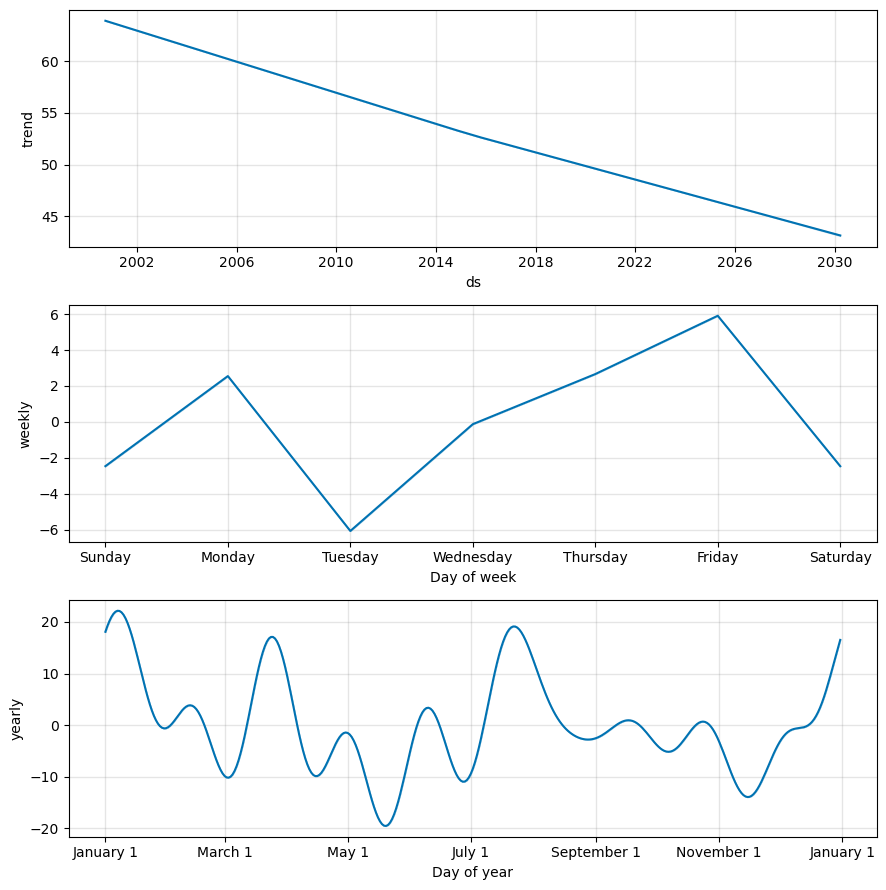

05:13:06 - cmdstanpy - INFO - Chain [1] start processing
05:13:06 - cmdstanpy - INFO - Chain [1] done processing


Seasonality Analysis for Cluster 1


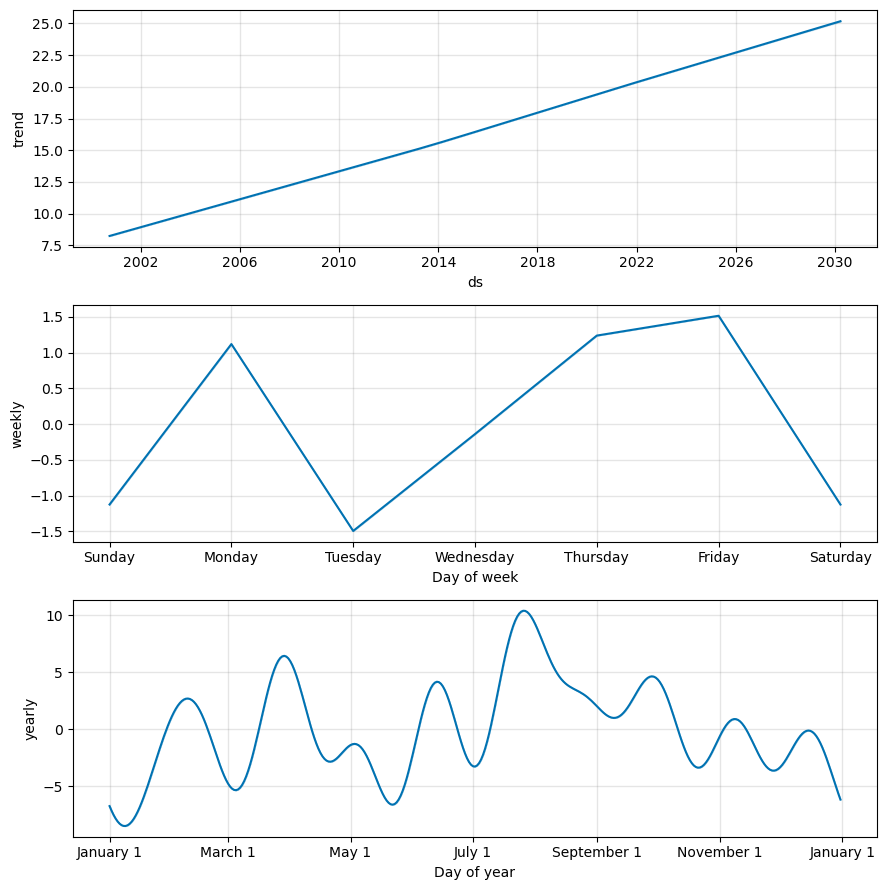

05:13:07 - cmdstanpy - INFO - Chain [1] start processing
05:13:07 - cmdstanpy - INFO - Chain [1] done processing


Seasonality Analysis for Cluster 2


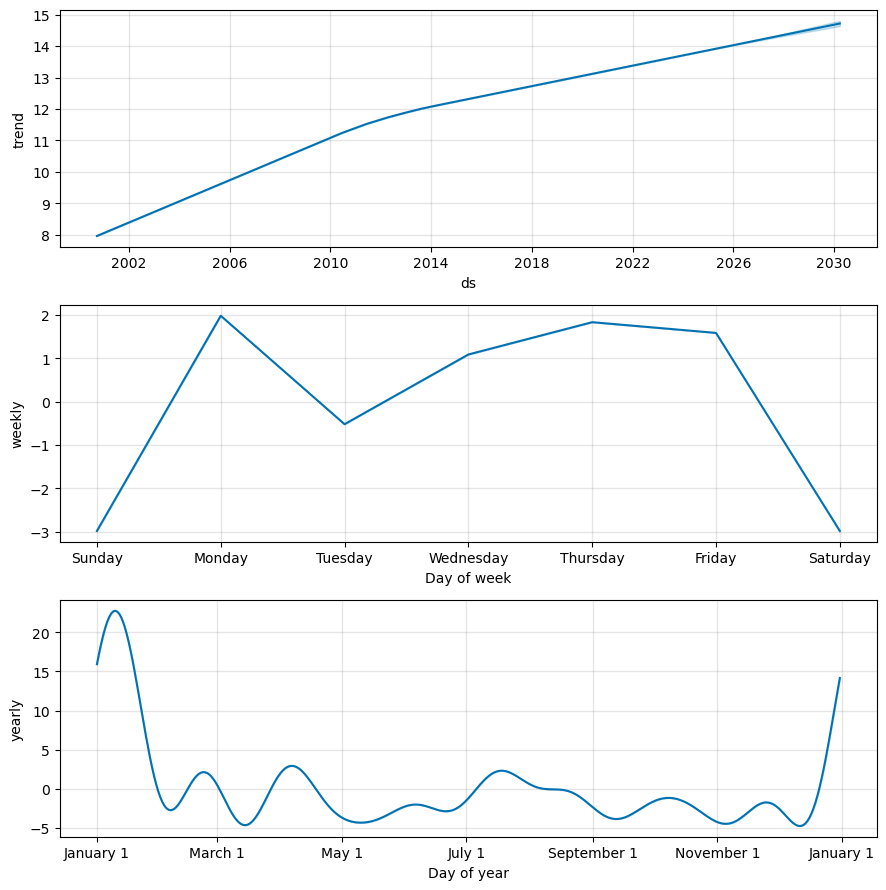

05:13:08 - cmdstanpy - INFO - Chain [1] start processing
05:13:08 - cmdstanpy - INFO - Chain [1] done processing


Seasonality Analysis for Cluster 3


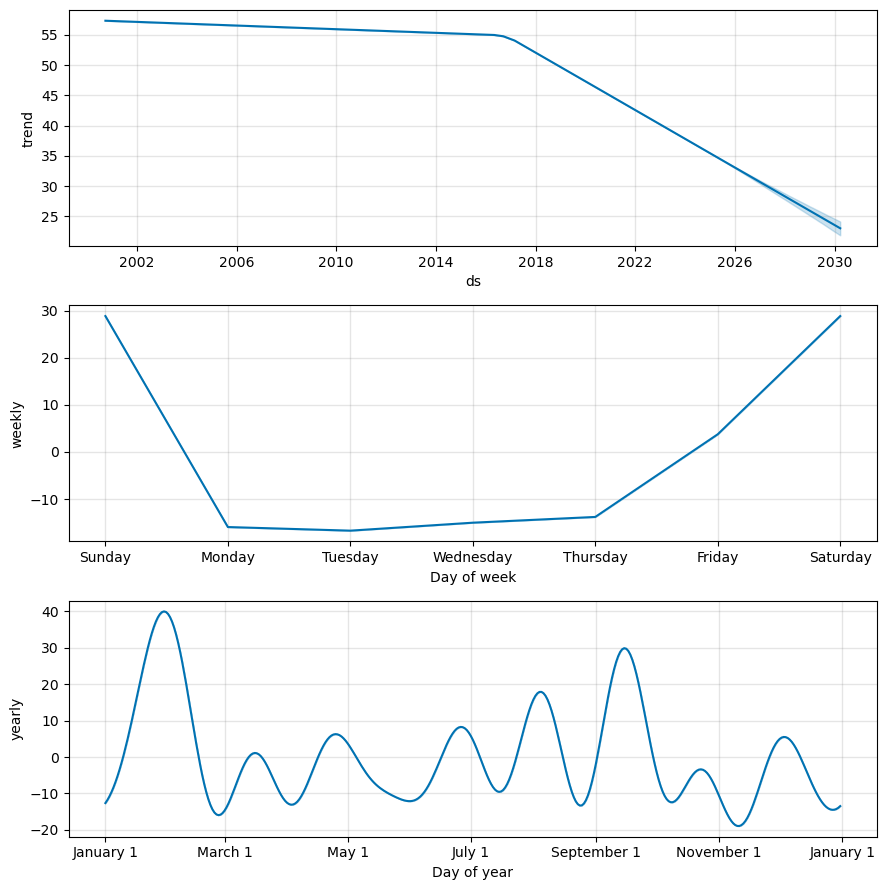

05:13:09 - cmdstanpy - INFO - Chain [1] start processing
05:13:09 - cmdstanpy - INFO - Chain [1] done processing


Seasonality Analysis for Cluster 4


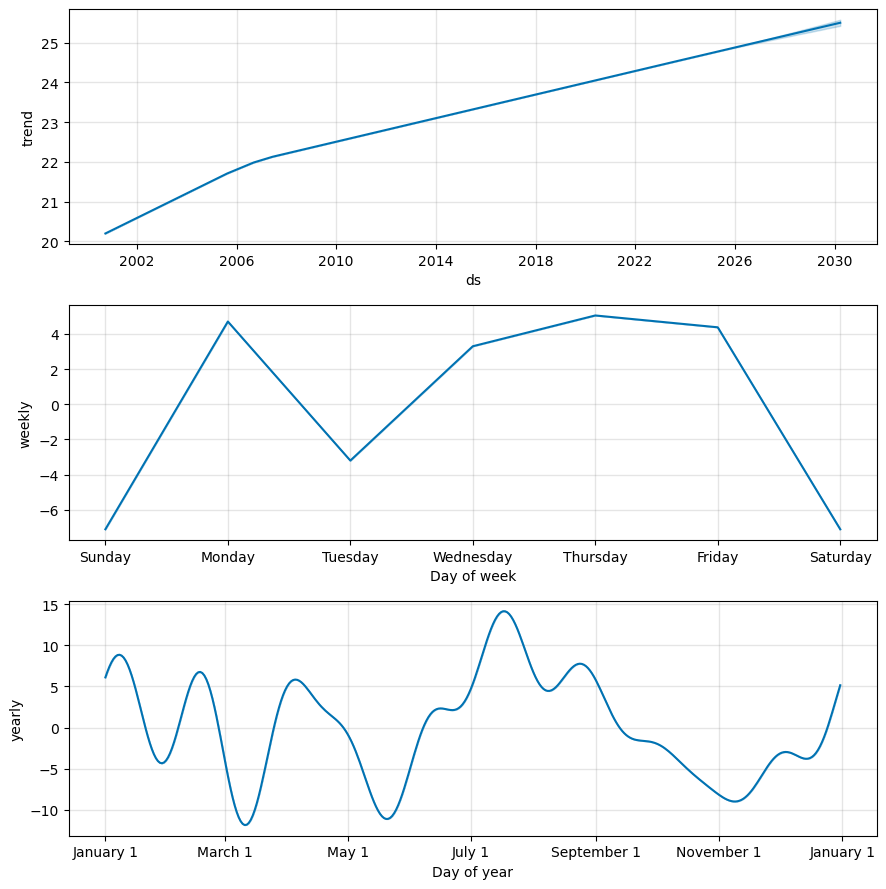

In [45]:
seasonality_results = {}

for cluster in cluster_counts['cluster'].unique():
    cluster_data = cluster_counts[cluster_counts['cluster'] == cluster]
    cluster_data = cluster_data.rename(columns={'date': 'ds', 'count': 'y'})
    
    model = Prophet()
    model.fit(cluster_data)
    
    future = model.make_future_dataframe(periods=2000)
    forecast = model.predict(future)
    
    print(f"Seasonality Analysis for Cluster {cluster}")
    fig = model.plot_components(forecast)
    plt.show()


test of a counter factual: the 2016 peace referendum

05:14:34 - cmdstanpy - INFO - Chain [1] start processing
05:14:34 - cmdstanpy - INFO - Chain [1] done processing


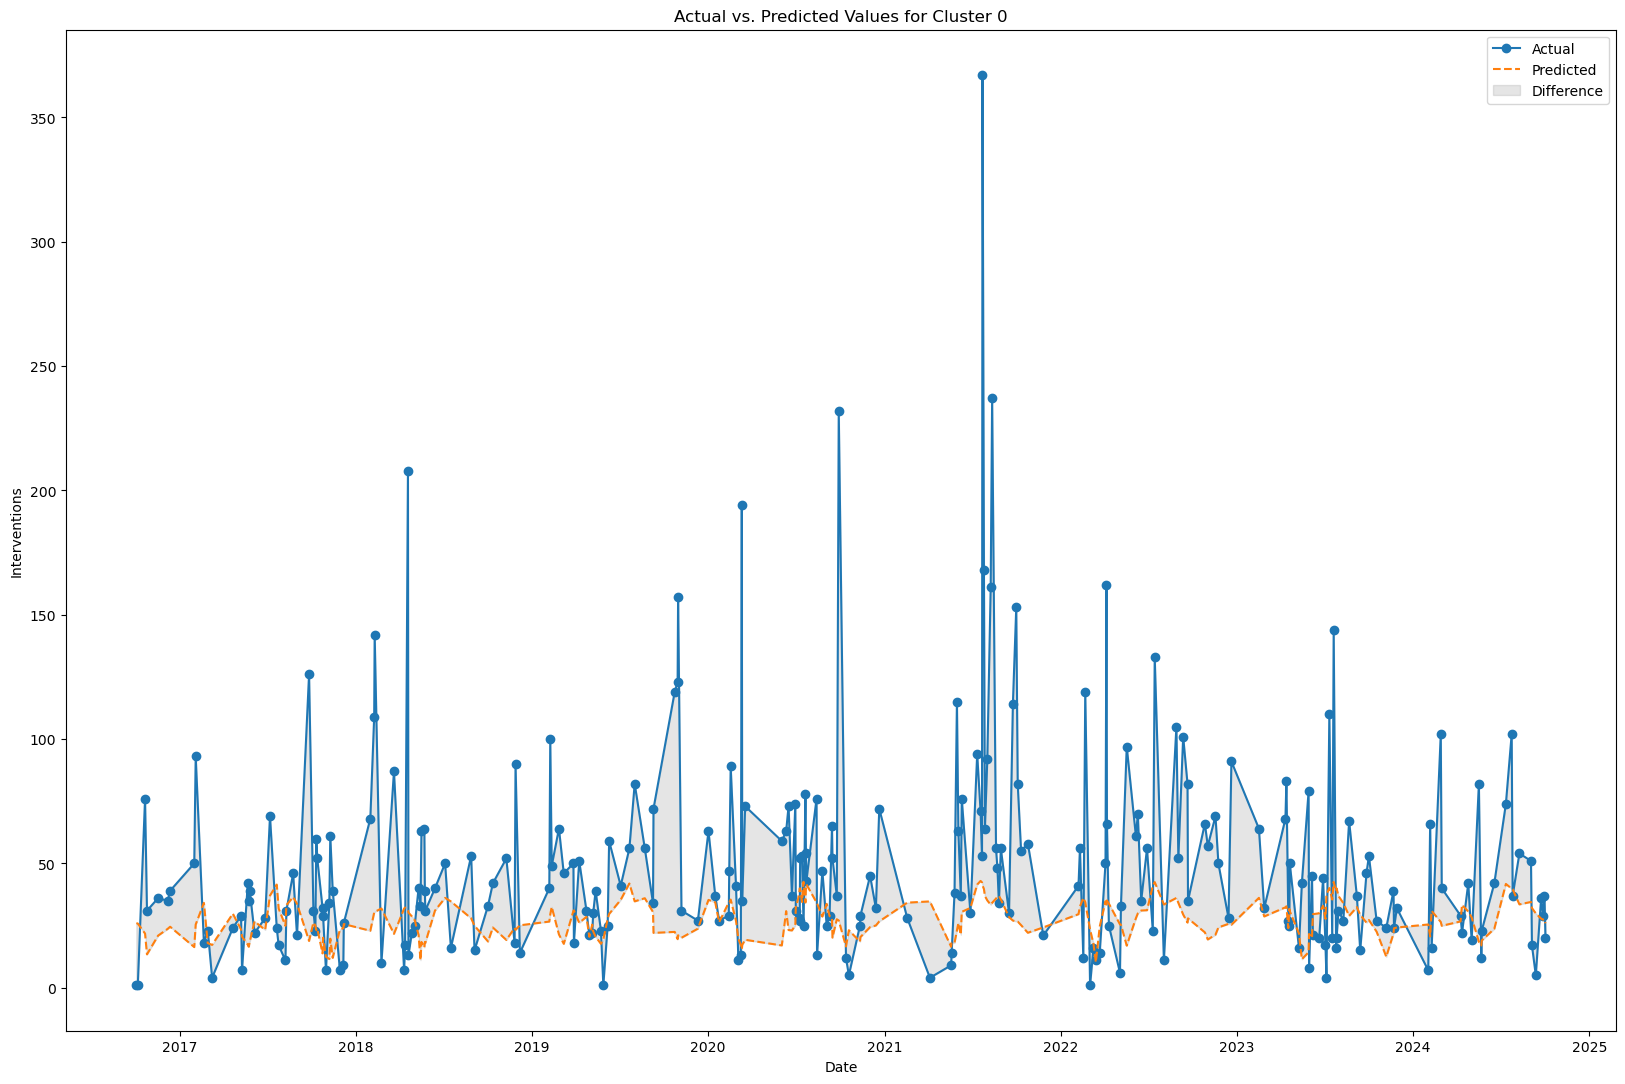

05:14:35 - cmdstanpy - INFO - Chain [1] start processing
05:14:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 29.92077245416581


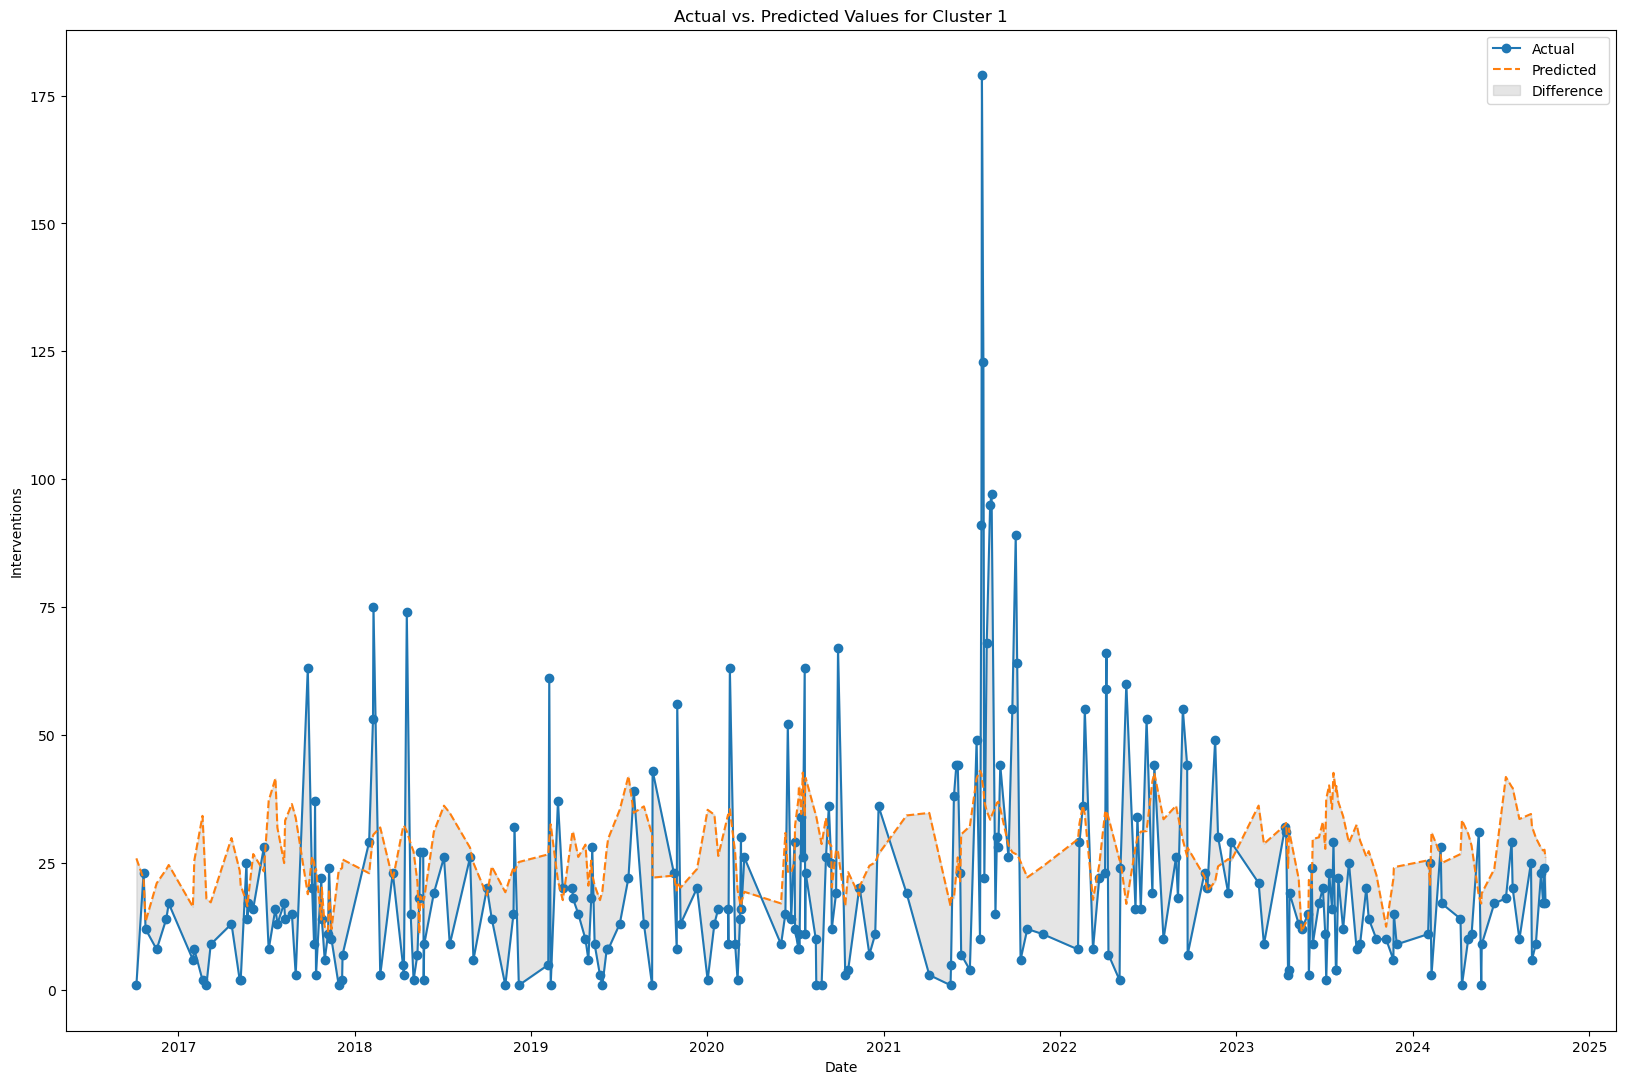

05:14:35 - cmdstanpy - INFO - Chain [1] start processing
05:14:35 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 17.056841176548595


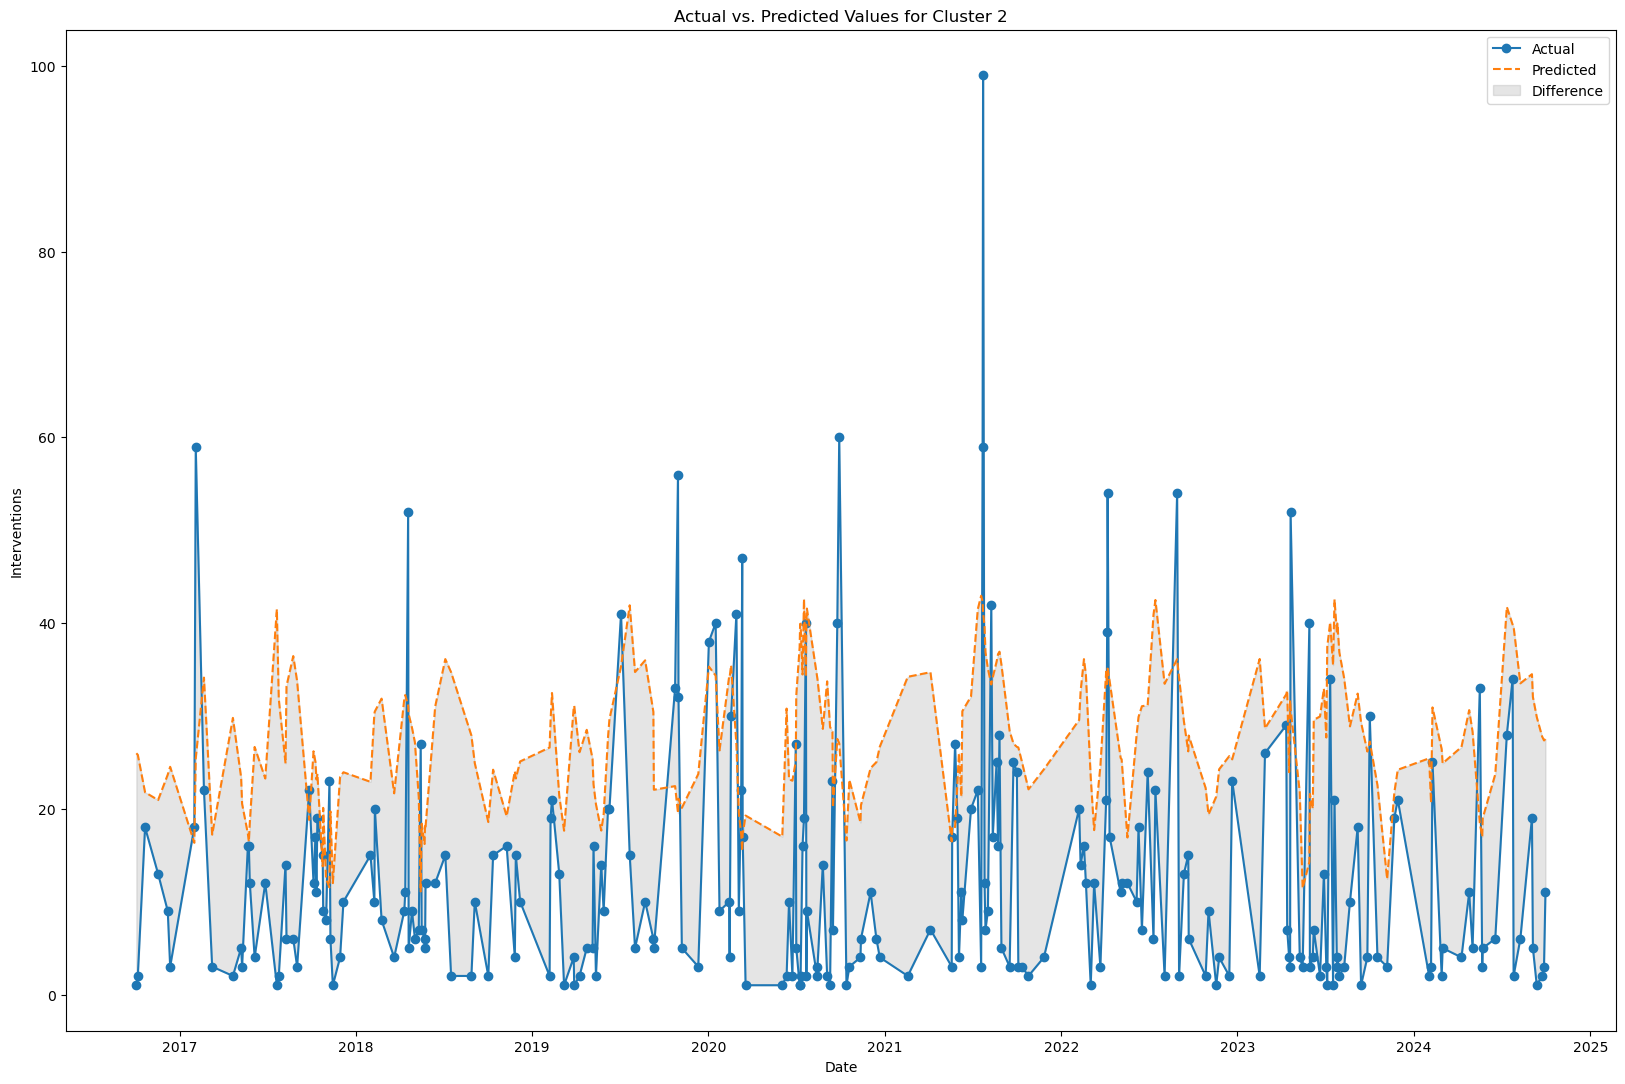

05:14:36 - cmdstanpy - INFO - Chain [1] start processing
05:14:36 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 18.26902410652599


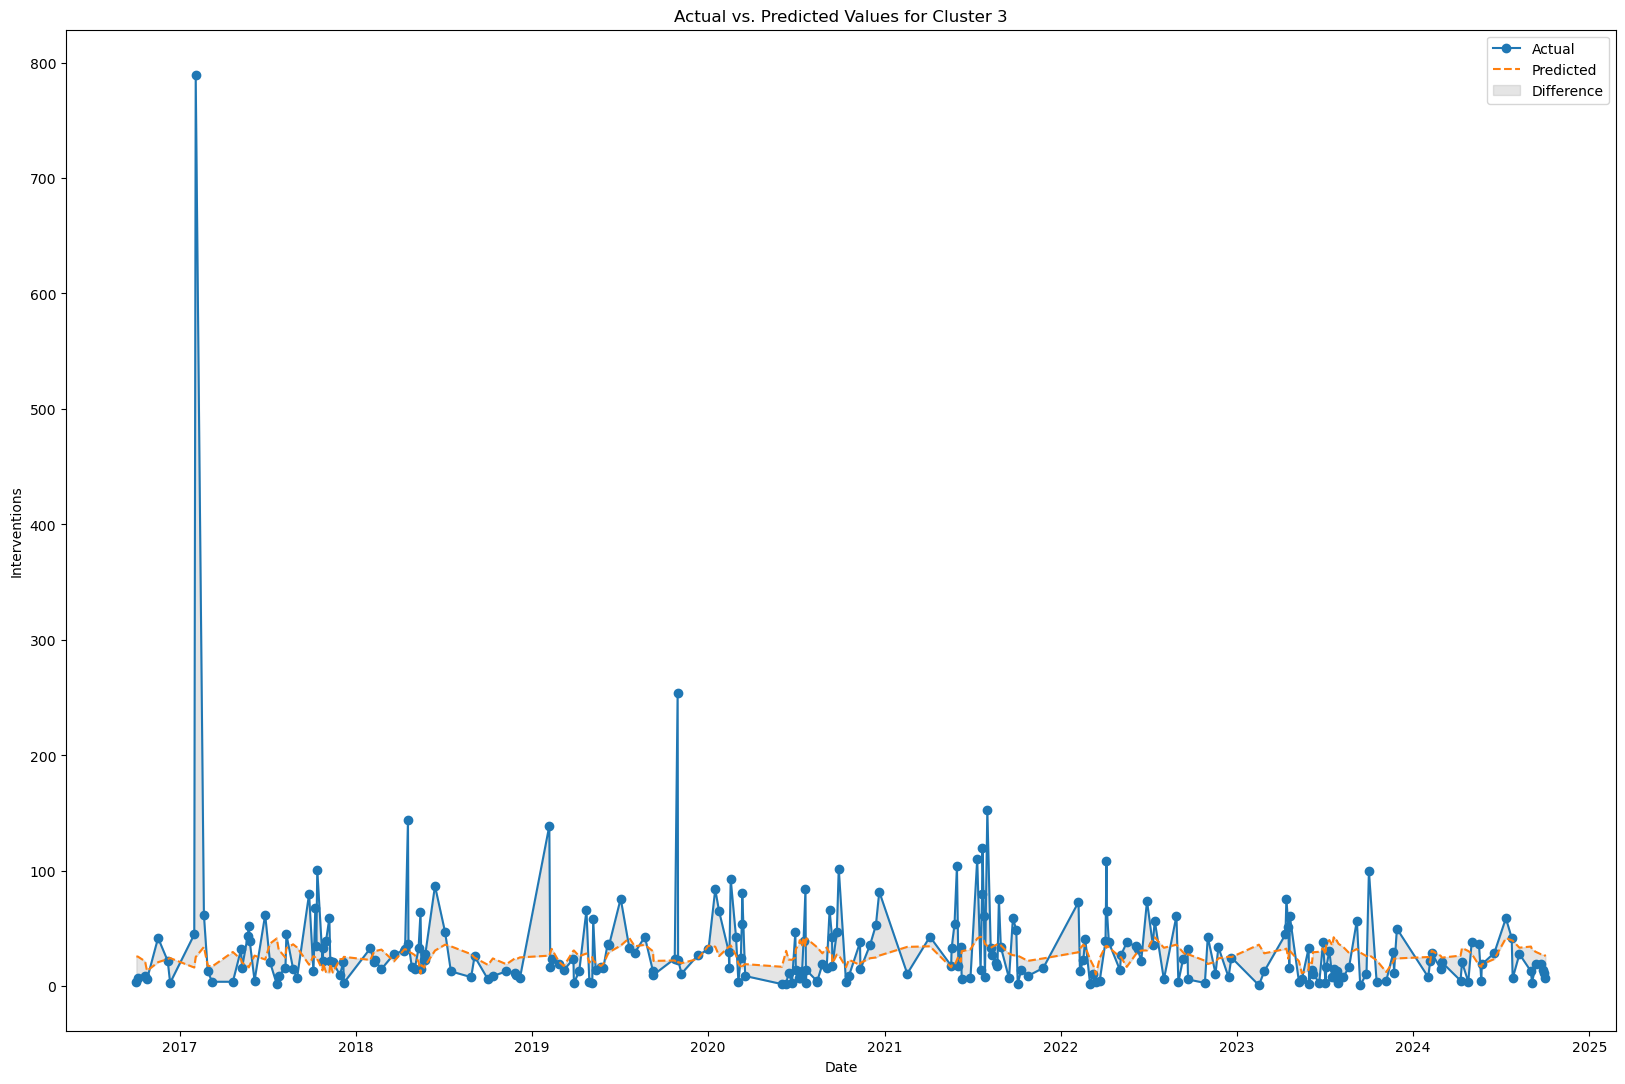

05:14:37 - cmdstanpy - INFO - Chain [1] start processing
05:14:37 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 24.146560102895105


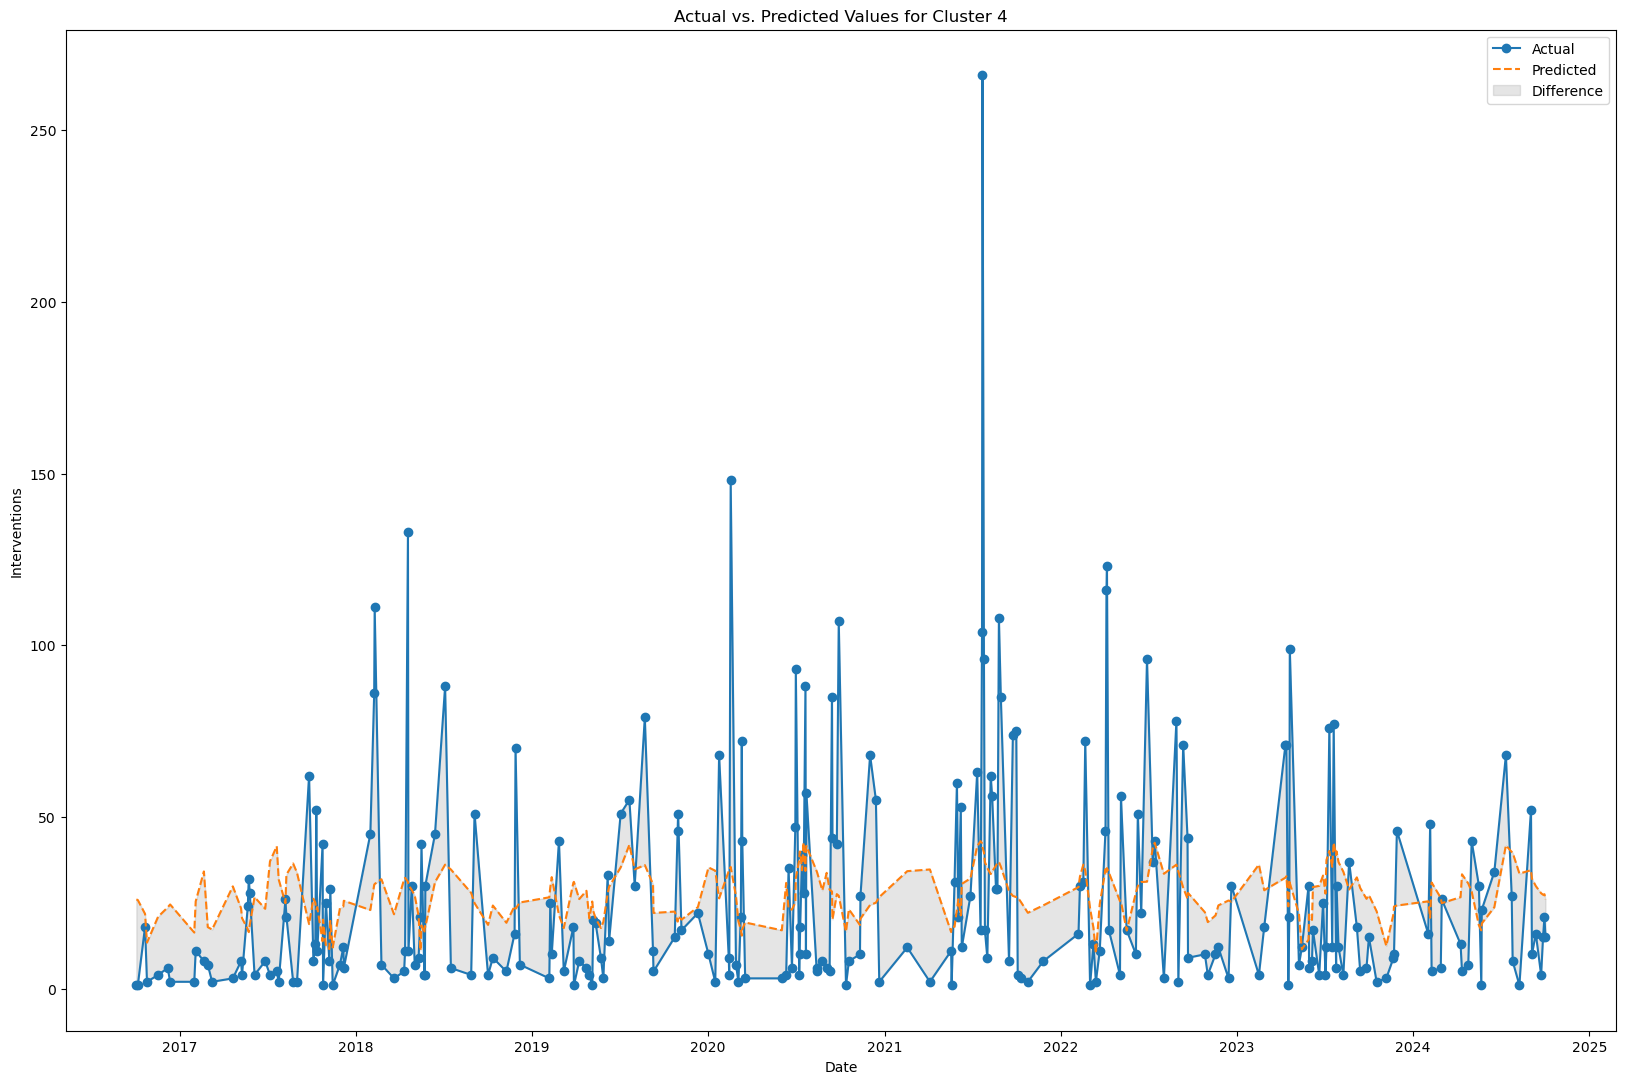

Mean Absolute Error: 23.205234489659674


In [ ]:
referendum_date = dd.to_datetime('2016-10-02')

for cluster in cluster_counts['cluster'].unique():
    cluster_data = cluster_counts[cluster_counts['cluster'] == cluster]
    cluster_data = cluster_data.rename(columns={'date': 'ds', 'count': 'y'})
    
    training_data = cluster_data[cluster_data['ds'] <= referendum_date]
    testing_data = cluster_data[cluster_data['ds'] > referendum_date]

    model_actual = Prophet()
    model_actual.fit(training_data)
    
    future = model.make_future_dataframe(periods=len(testing_data), freq='D')
    forecast = model.predict(future)

    predicted_values = forecast[forecast['ds'] > referendum_date]

    comparison = dd.merge(
    predicted_values[['ds', 'yhat']],
    testing_data[['ds', 'y']],
    on='ds',
    how='inner'
    )

    plt.figure(figsize=(20, 13))
    plt.plot(comparison['ds'], comparison['y'], label='Actual', marker='o')
    plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', linestyle='--')
    plt.fill_between(comparison['ds'], 
                    comparison['yhat'], comparison['y'], 
                    color='gray', alpha=0.2, label='Difference')
    plt.xlabel('Date')
    plt.ylabel('Interventions')
    plt.title('Actual vs. Predicted Values for Cluster {}'.format(cluster))
    plt.legend()
    plt.show()

    comparison['difference'] = comparison['y'] - comparison['yhat']
    mae = abs(comparison['difference']).mean()
    print(f"Mean Absolute Error: {mae}")